In [1]:
import pandas as pd
import numpy as np
print('Service libraries imported')

Service libraries imported


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
print('Classifiers imported')

Classifiers imported


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,f1_score
print('Metrics imported')

Metrics imported


In [5]:
from sklearn.model_selection import GridSearchCV
print('Grid search imported')

Grid search imported


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
df=pd.read_csv('Pathdip_shuffled.csv')

In [8]:
df.head(5)

REACTOME....Metabolism  REACTOME.1....Metabolism.of.proteins  \
0                       1                                     0   
1                       0                                     0   
2                       0                                     0   
3                       1                                     1   
4                       0                                     0   

   REACTOME.2....Immune.System  REACTOME.3....Disease  \
0                            0                      0   
1                            1                      0   
2                            0                      0   
3                            1                      1   
4                            1                      0   

   OntoCancro....Expanded.Apoptosis  \
0                                 0   
1                                 0   
2                                 0   
3                                 0   
4                                 0   

   REACTOME.4....Gene.expression..Transcription.  \
0                                              0   
1                                              0   
2                                              0   
3                                              1   
4                                              0   

   systems.biology.org....Macrophage_Map_Update_ver2_re  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  1      
4                                                  0      

   REACTOME.5....RNA.Polymerase.II.Transcription  \
0                                              0   
1                                              0   
2                                              0   
3                                              1   
4                                              0   

   REACTOME.6....Generic.Transcription.Pathway  \
0                                            0   
1                                            0   
2                                            0   
3                                            1   
4                                            0   

   ACSN2....MITOCHONDRIAL_METABOLISM  ...  \
0                                  1  ...   
1                                  0  ...   
2                                  0  ...   
3                                  0  ...   
4                                  0  ...   

   WikiPathways.185....Ethanol.metabolism.resulting.in.production.of.ROS.by.CYP2E1  \
0                                                  0                                 
1                                                  0                                 
2                                                  0                                 
3                                                  0                                 
4                                                  0                                 

   WikiPathways.186....MFAP5.effect.on.permeability.and.motility.of.endothelial.cells.via.cytoskeleton.rearrangement  \
0                                                  0                                                                   
1                                                  0                                                                   
2                                                  0                                                                   
3                                                  0                                                                   
4                                                  0                                                                   

   WikiPathways.187....Mammary.gland.development.pathway...Embryonic.development..Stage.1.of.4.  \
0                                                  0                                              
1                                

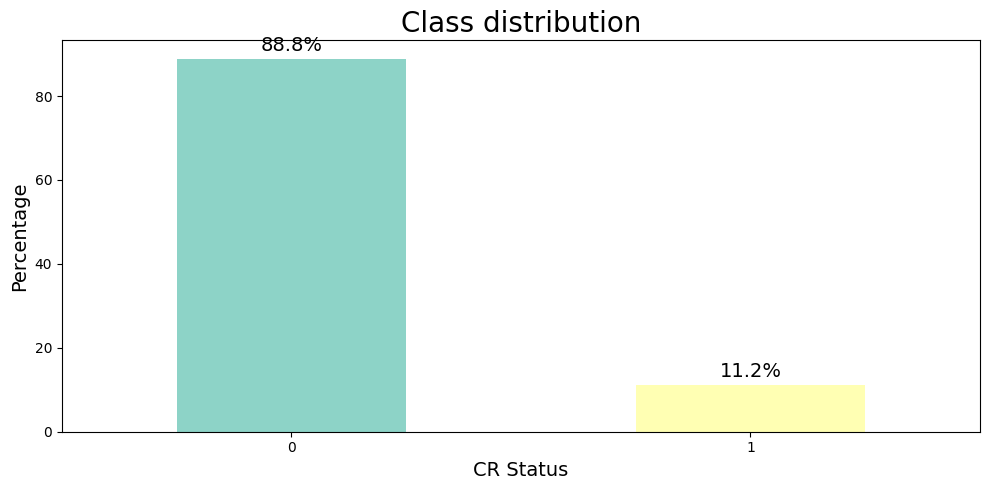

In [9]:
# Calculate class distribution percentages
class_distribution = df['Class'].value_counts(normalize=True) * 100

# Create a color palette with different colors for each bar
color_palette = plt.cm.Set3.colors[:len(class_distribution)]

# Create a bar plot
ax = class_distribution.plot(kind='bar', figsize=(10, 5), color=color_palette)

# Annotate the bars with percentages
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=14)

# Customize plot labels and title
plt.title('Class distribution', fontsize=20)
plt.xlabel('CR Status', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()








In [10]:
#split the df into 10 equal parts for manual cross validation
total_rows = len(df)
size_of_each_part = total_rows // 10
remainder = total_rows % 10

# Step 2: Split the DataFrame into 10 equal parts
dfs = []
start_index = 0
for i in range(10):
    end_index = start_index + size_of_each_part + (1 if i < remainder else 0)
    part_df = df.iloc[start_index:end_index].reset_index(drop=True)
    dfs.append(part_df)
    start_index = end_index

In [11]:
import time

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
#APPLICATION OF MACHINE LEARNING ALGORITHMS TO DEFAULT ATTRIBUTES
start_time = time.time()

# Initialize the dictionary to store metrics for each classifier
brf_metrics_dict = {}
rf_metrics_dict = {}
xgb_metrics_dict = {}

columns=list(df.columns)
# Loop through the dfs list for cross-validation
for i in range(len(dfs)):
    df_test=dfs[i]
    # Combine all DataFrames except the current DataFrame to create the training and validation sets
    train_val_dfs = [df for df in dfs if df is not df_test]
    df_train_val = pd.concat(train_val_dfs, ignore_index=True)

    # Split the combined DataFrame into X and y for training
    X_train_val = df_train_val.drop(columns=['Class'])
    y_train_val = df_train_val['Class']

    # Split the test DataFrame into X and y
    X_test = df_test.drop(columns=['Class'])
    y_test = df_test['Class']

    # Create the parameter grid for BalancedRandomForestClassifier
    brf_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt','sqrt*2','sqrt/2']
    }

    # Create the GridSearchCV instance for BRF
    brf_classifier = GridSearchCV(BalancedRandomForestClassifier(), brf_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    brf_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = brf_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    brf_metrics_dict[f"brf_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for brf_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()

    # Create the parameter grid for RandomForestClassifier
    rf_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt','sqrt*2','sqrt/2']

    }

    # Create the GridSearchCV instance for RF
    rf_classifier = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    rf_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = rf_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    rf_metrics_dict[f"rf_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for rf_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()


    # Create the parameter grid for XGB classifier
    xgb_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 5, 10],
        'colsample_bytree': [0.6, 0.8,1.0]
    }

    # Create the GridSearchCV instance for XGB
    xgb_classifier = GridSearchCV(xgb.XGBClassifier(), xgb_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    xgb_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = xgb_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    xgb_metrics_dict[f"xgb_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for xgb_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()

# Calculate average metrics across all folds for brf
brf_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in brf_metrics_dict.values()])
                   for metric_name in brf_metrics_dict[next(iter(brf_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics BRF:")
for metric_name, metric_value in brf_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()
# Calculate average metrics across all folds for rf
rf_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in rf_metrics_dict.values()])
                   for metric_name in rf_metrics_dict[next(iter(rf_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics RF:")
for metric_name, metric_value in rf_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()
# Calculate average metrics across all folds for xgb
xgb_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in xgb_metrics_dict.values()])
                   for metric_name in xgb_metrics_dict[next(iter(xgb_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics XGB:")
for metric_name, metric_value in xgb_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()

# Access the best estimators for each classifier
best_brf_estimator = brf_classifier.best_estimator_
best_rf_estimator = rf_classifier.best_estimator_
best_xgb_estimator = xgb_classifier.best_estimator_

end_time = time.time()
duration = end_time - start_time
print(f'This block executed in: {duration/60} minutes')

Metrics for brf_classifier_0:
Accuracy: 0.8585858585858586
Precision: 0.5
Recall: 0.42857142857142855
ROC AUC: 0.6789915966386555
F1: 0.4615384615384615

Metrics for rf_classifier_0:
Accuracy: 0.8888888888888888
Precision: 1.0
Recall: 0.21428571428571427
ROC AUC: 0.6071428571428571
F1: 0.35294117647058826

Metrics for xgb_classifier_0:
Accuracy: 0.9292929292929293
Precision: 0.8888888888888888
Recall: 0.5714285714285714
ROC AUC: 0.7798319327731092
F1: 0.6956521739130435

Metrics for brf_classifier_1:
Accuracy: 0.8888888888888888
Precision: 0.38461538461538464
Recall: 0.625
ROC AUC: 0.7685439560439561
F1: 0.4761904761904762

Metrics for rf_classifier_1:
Accuracy: 0.9292929292929293
Precision: 0.6666666666666666
Recall: 0.25
ROC AUC: 0.6195054945054945
F1: 0.36363636363636365

Metrics for xgb_classifier_1:
Accuracy: 0.9292929292929293
Precision: 0.5714285714285714
Recall: 0.5
ROC AUC: 0.7335164835164835
F1: 0.5333333333333333

Metrics for brf_classifier_2:
Accuracy: 0.8181818181818182
Pr

In [14]:
# Access the best estimator for each classifier
best_brf_estimator = brf_classifier.best_estimator_
best_rf_estimator = rf_classifier.best_estimator_
best_xgb_estimator = xgb_classifier.best_estimator_

# Display the hyperparameters of the best BalancedRandomForestClassifier
print("Best Hyperparameters for Balanced Random Forest:")
print(best_brf_estimator.get_params())
print()

# Display the hyperparameters of the best RandomForestClassifier
print("Best Hyperparameters for Random Forest:")
print(best_rf_estimator.get_params())
print()

# Display the hyperparameters of the best XGBoostClassifier
print("Best Hyperparameters for XGBoost:")
print(best_xgb_estimator.get_params())


Best Hyperparameters for Balanced Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}

Best Hyperparameters for Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Best Hyperparameters for XGBoost:
{'objective': 'binary:logistic', 'use_labe

In [15]:
# Initialize dictionaries to store summed confusion matrices for each classifier
brf_sum_conf_matrix = np.zeros((2, 2))
rf_sum_conf_matrix = np.zeros((2, 2))
xgb_sum_conf_matrix = np.zeros((2, 2))

# Loop through the metrics dictionaries and accumulate confusion matrices
for metrics_dict in [brf_metrics_dict, rf_metrics_dict, xgb_metrics_dict]:
    for key, metrics in metrics_dict.items():
        conf_matrix = metrics.get('Confusion Matrix', None)
        if conf_matrix is not None:
            if 'brf' in key:
                brf_sum_conf_matrix += conf_matrix
            elif 'rf' in key:
                rf_sum_conf_matrix += conf_matrix
            elif 'xgb' in key:
                xgb_sum_conf_matrix += conf_matrix

# Print summed confusion matrices
print("Summed Confusion Matrix for BRF:")
print(brf_sum_conf_matrix)

print("Summed Confusion Matrix for RF:")
print(rf_sum_conf_matrix)

print("Summed Confusion Matrix for XGB:")
print(xgb_sum_conf_matrix)


Summed Confusion Matrix for BRF:
[[776. 100.]
 [ 49.  61.]]
Summed Confusion Matrix for RF:
[[864.  12.]
 [ 80.  30.]]
Summed Confusion Matrix for XGB:
[[849.  27.]
 [ 65.  45.]]


In [16]:
from math import log2
import math as math

# Function to calculate entropy
def calculate_entropy(labels):
    # Get the unique labels and their counts
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    entropy = 0

    # Calculate the entropy for each label
    for count in label_counts:
        probability = count / total_samples
        entropy -= probability * log2(probability)

    return entropy

# Function to calculate information gain
def calculate_information_gain(df, Class):
    information_gains = {}

    # Iterate over each attribute column in the DataFrame
    for attribute in df.columns:
        if attribute != Class:
            attribute_values = df[attribute].unique()
            attribute_entropy = 0

            # Calculate the entropy for each attribute value
            for value in attribute_values:
                subset = df[df[attribute] == value]
                subset_entropy = calculate_entropy(subset[Class])
                subset_probability = len(subset) / len(df)
                attribute_entropy += subset_probability * subset_entropy

            # Calculate the entropy of the target class
            Class_entropy = calculate_entropy(df[Class])

            # Calculate the information gain for the attribute
            information_gains[attribute] = Class_entropy - attribute_entropy

    return information_gains


In [18]:
#APPLICATION OF MACHINE LEARNING ALGORITHMS TO CONSTRUCTED X-OF-N WITH JACCARD SELECTION ATTRIBUTE DATASET
start_time = time.time()

# Initialize the dictionary to store metrics for each classifier
brf_metrics_dict = {}
rf_metrics_dict = {}
xgb_metrics_dict = {}

# Loop through the dfs list for cross-validation
for i in range(len(dfs)):
    df_test=dfs[i]

    # Combine all DataFrames except the current DataFrame to create the training and validation sets
    train_val_dfs = [df for df in dfs if df is not df_test]
    df_train_val = pd.concat(train_val_dfs, ignore_index=True)
    # Get columns present in df_test
    columns_in_df_test = df_test.columns

    # Drop columns in df_train_val that are not in df_test
    columns_to_drop = [col for col in df_train_val.columns if col not in columns_in_df_test]
    df_train_val = df_train_val.drop(columns=columns_to_drop)

    # Specify the name of the Class column
    Class = "Class"
    # Calculate the information gain for every attribute
    information_gains = calculate_information_gain(df_train_val, Class)
    # Sort the attributes based on information gain in descending order
    Attr_List = sorted(information_gains, key=information_gains.get, reverse=True)

    Max_N_Size = 5 #x of n attribute size
    count = 0  # Initialize count variable

    # Iterate over Attr_List while its length is greater than or equal to Max_N_Size
    while len(Attr_List) >= Max_N_Size:
        # Select the first attribute from Attr_List
        first_attr = Attr_List[0]
        jaccard_score_dict = {}

        # Compute the Jaccard similarity between the first attribute and each column in df_train_val
        for col in df_train_val.columns:
            if col != first_attr:
                intersection = set(df_train_val[first_attr]) & set(df_train_val[col])
                union = set(df_train_val[first_attr]) | set(df_train_val[col])
                jaccard_score = len(intersection) / len(union)
                jaccard_score_dict[col] = jaccard_score

        # Sort the Jaccard scores in descending order and select the top 4 columns
        sorted_dict = dict(sorted(jaccard_score_dict.items(), key=lambda x: x[1], reverse=True))
        selected_attrs = [first_attr] + list(sorted_dict.keys())[:4]

        # Create a combo_name by joining the selected attributes with an underscore
        x_of_n_name = '_'.join(selected_attrs)

        # Calculate the sum of the selected attributes along the rows and assign it to a new column in df_train_val with the combo_name
        df_train_val[x_of_n_name] = df_train_val[selected_attrs].sum(axis=1)
        df_test[x_of_n_name] = df_test[selected_attrs].sum(axis=1)

        # Remove the selected attributes from Attr_List and df_train_val
        Attr_List = [attr for attr in Attr_List if attr not in selected_attrs]
        df_train_val = df_train_val.drop(columns=selected_attrs)
        df_test = df_test.drop(columns=selected_attrs)
        count += 1  # Increment count by 1 after processing a complete group

    # Process any remaining attributes that do not form a complete group
    remaining_attrs = Attr_List

    if remaining_attrs:
        # Calculate the number of remaining columns
        remaining_columns = len(remaining_attrs)

        # Create combo_names for the remaining attributes in groups of Max_N_Size
        for j in range(0, remaining_columns, Max_N_Size):

            combo_attrs = remaining_attrs[j:j+Max_N_Size]

            x_of_n_name = '_'.join(combo_attrs)

            df_train_val[x_of_n_name] = df_train_val[combo_attrs].sum(axis=1)

            df_test[x_of_n_name] = df_test[combo_attrs].sum(axis=1)

            df_train_val = df_train_val.drop(columns=combo_attrs)

            df_test = df_test.drop(columns=combo_attrs)

    # Save the train DataFrame to a CSV file without the index column
    train_file_name = f'x-of-n-pathdip-train-jaccard{i}.csv'  # Create the file name for the current value of i
    df_train_val.to_csv(train_file_name, index=False)

    # Save the test DataFrame to a CSV file without the index column
    test_file_name = f'x-of-n-pathdip-test-jaccard{i}.csv'  # Create the file name for the current value of i
    df_test.to_csv(test_file_name, index=False)



  # Split the combined DataFrame into X and y for training
    X_train_val = df_train_val.drop(columns=['Class'])
    y_train_val = df_train_val['Class']

    # Split the test DataFrame into X and y
    X_test = df_test.drop(columns=['Class'])
    y_test = df_test['Class']

   # Create the parameter grid for BalancedRandomForestClassifier
    brf_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt','sqrt*2','sqrt/2']
    }

    # Create the GridSearchCV instance for BRF
    brf_classifier = GridSearchCV(BalancedRandomForestClassifier(), brf_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    brf_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = brf_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    brf_metrics_dict[f"brf_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for brf_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()

    # Create the parameter grid for RandomForestClassifier
    rf_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt','sqrt*2','sqrt/2']

    }

    # Create the GridSearchCV instance for RF
    rf_classifier = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    rf_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = rf_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    rf_metrics_dict[f"rf_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for rf_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()


    # Create the parameter grid for XGB classifier
    xgb_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 5, 10],
        'colsample_bytree': [0.6, 0.8,1.0]
    }

    # Create the GridSearchCV instance for XGB
    xgb_classifier = GridSearchCV(xgb.XGBClassifier(), xgb_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    xgb_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = xgb_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    xgb_metrics_dict[f"xgb_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for xgb_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()

# Calculate average metrics across all folds for brf
brf_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in brf_metrics_dict.values()])
                   for metric_name in brf_metrics_dict[next(iter(brf_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics BRF:")
for metric_name, metric_value in brf_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()
# Calculate average metrics across all folds for rf
rf_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in rf_metrics_dict.values()])
                   for metric_name in rf_metrics_dict[next(iter(rf_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics RF:")
for metric_name, metric_value in rf_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()
# Calculate average metrics across all folds for xgb
xgb_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in xgb_metrics_dict.values()])
                   for metric_name in xgb_metrics_dict[next(iter(xgb_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics XGB:")
for metric_name, metric_value in xgb_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()

# Access the best estimators for each classifier
best_brf_estimator = brf_classifier.best_estimator_
best_rf_estimator = rf_classifier.best_estimator_
best_xgb_estimator = xgb_classifier.best_estimator_

end_time = time.time()
duration = end_time - start_time
print(f'This block executed in: {duration/60} minutes')

Metrics for brf_classifier_0:
Accuracy: 0.797979797979798
Precision: 0.4
Recall: 0.8571428571428571
ROC AUC: 0.8226890756302521
F1: 0.5454545454545455

Metrics for rf_classifier_0:
Accuracy: 0.9090909090909091
Precision: 1.0
Recall: 0.35714285714285715
ROC AUC: 0.6785714285714286
F1: 0.5263157894736842

Metrics for xgb_classifier_0:
Accuracy: 0.9292929292929293
Precision: 0.8181818181818182
Recall: 0.6428571428571429
ROC AUC: 0.8096638655462184
F1: 0.7200000000000001

Metrics for brf_classifier_1:
Accuracy: 0.7777777777777778
Precision: 0.23076923076923078
Recall: 0.75
ROC AUC: 0.7651098901098902
F1: 0.3529411764705882

Metrics for rf_classifier_1:
Accuracy: 0.9292929292929293
Precision: 1.0
Recall: 0.125
ROC AUC: 0.5625
F1: 0.2222222222222222

Metrics for xgb_classifier_1:
Accuracy: 0.9090909090909091
Precision: 0.4
Recall: 0.25
ROC AUC: 0.6085164835164835
F1: 0.3076923076923077

Metrics for brf_classifier_2:
Accuracy: 0.7171717171717171
Precision: 0.30303030303030304
Recall: 0.666666

In [19]:
# Access the best estimator for each classifier
best_brf_estimator = brf_classifier.best_estimator_
best_rf_estimator = rf_classifier.best_estimator_
best_xgb_estimator = xgb_classifier.best_estimator_

# Display the hyperparameters of the best BalancedRandomForestClassifier
print("Best Hyperparameters for Balanced Random Forest:")
print(best_brf_estimator.get_params())
print()

# Display the hyperparameters of the best RandomForestClassifier
print("Best Hyperparameters for Random Forest:")
print(best_rf_estimator.get_params())
print()

# Display the hyperparameters of the best XGBoostClassifier
print("Best Hyperparameters for XGBoost:")
print(best_xgb_estimator.get_params())


Best Hyperparameters for Balanced Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}

Best Hyperparameters for Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Best Hyperparameters for XGBoost:
{'objective': 'binary:logistic', 'use_labe

In [20]:
# Initialize dictionaries to store summed confusion matrices for each classifier
brf_sum_conf_matrix = np.zeros((2, 2))
rf_sum_conf_matrix = np.zeros((2, 2))
xgb_sum_conf_matrix = np.zeros((2, 2))

# Loop through the metrics dictionaries and accumulate confusion matrices
for metrics_dict in [brf_metrics_dict, rf_metrics_dict, xgb_metrics_dict]:
    for key, metrics in metrics_dict.items():
        conf_matrix = metrics.get('Confusion Matrix', None)
        if conf_matrix is not None:
            if 'brf' in key:
                brf_sum_conf_matrix += conf_matrix
            elif 'rf' in key:
                rf_sum_conf_matrix += conf_matrix
            elif 'xgb' in key:
                xgb_sum_conf_matrix += conf_matrix

# Print summed confusion matrices
print("Summed Confusion Matrix for BRF:")
print(brf_sum_conf_matrix)

print("Summed Confusion Matrix for RF:")
print(rf_sum_conf_matrix)

print("Summed Confusion Matrix for XGB:")
print(xgb_sum_conf_matrix)


Summed Confusion Matrix for BRF:
[[668. 208.]
 [ 33.  77.]]
Summed Confusion Matrix for RF:
[[870.   6.]
 [ 85.  25.]]
Summed Confusion Matrix for XGB:
[[842.  34.]
 [ 68.  42.]]


In [21]:
#split the df into same 10 folds
total_rows = len(df)
size_of_each_part = total_rows // 10
remainder = total_rows % 10

# Step 2: Split the DataFrame into 10 equal parts
dfs = []
start_index = 0
for i in range(10):
    end_index = start_index + size_of_each_part + (1 if i < remainder else 0)
    part_df = df.iloc[start_index:end_index].reset_index(drop=True)
    dfs.append(part_df)
    start_index = end_index

In [22]:
#APPLICATION OF MACHINE LEARNING ALGORITHMS TO CONSTRUCTED X-OF-N WITH JACCARD SELECTION + ORIGINAL ATTRIBUTE DATASET
start_time = time.time()


# Initialize the dictionary to store metrics for each classifier
brf_metrics_dict = {}
rf_metrics_dict = {}
xgb_metrics_dict = {}

# Loop through the dfs list for cross-validation
for i in range(len(dfs)):
    df_test=dfs[i]
    # Combine all DataFrames except the current DataFrame to create the training and validation sets
    train_val_dfs = [df for df in dfs if df is not df_test]
    df_train_val = pd.concat(train_val_dfs, ignore_index=True)
    # Get columns present in df_test
    columns_in_df_test = df_test.columns

    # Drop columns in df_train_val that are not in df_test
    columns_to_drop = [col for col in df_train_val.columns if col not in columns_in_df_test]
    df_train_val = df_train_val.drop(columns=columns_to_drop)

    # load the corresponding x of n dataframe
    x_of_n_train_df = pd.read_csv(f'x-of-n-pathdip-train-jaccard{i}.csv')
    x_of_n_test_df = pd.read_csv(f'x-of-n-pathdip-test-jaccard{i}.csv')

    #drop the class because its the same as the original
    x_of_n_train_df = x_of_n_train_df.drop(columns=['Class'])
    x_of_n_test_df = x_of_n_test_df.drop(columns=['Class'])

    #reset index to avoid nan
    df_train_val.reset_index(drop=True, inplace=True)
    x_of_n_train_df.reset_index(drop=True, inplace=True)

    df_test.reset_index(drop=True, inplace=True)
    x_of_n_test_df.reset_index(drop=True, inplace=True)


    #append to original dataset
    df_train_val = pd.concat([df_train_val,x_of_n_train_df],axis=1)
    df_test = pd.concat([df_test,x_of_n_test_df],axis=1)

    # Split the combined DataFrame into X and y for training
    X_train_val = df_train_val.drop(columns=['Class'])
    y_train_val = df_train_val['Class']

    # Split the test DataFrame into X and y
    X_test = df_test.drop(columns=['Class'])
    y_test = df_test['Class']

    # Create the parameter grid for BalancedRandomForestClassifier
    brf_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt','sqrt*2','sqrt/2']
    }

    # Create the GridSearchCV instance for BRF
    brf_classifier = GridSearchCV(BalancedRandomForestClassifier(), brf_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    brf_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = brf_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    brf_metrics_dict[f"brf_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for brf_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()

    # Create the parameter grid for RandomForestClassifier
    rf_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt','sqrt*2','sqrt/2']

    }

    # Create the GridSearchCV instance for RF
    rf_classifier = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    rf_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = rf_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    rf_metrics_dict[f"rf_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for rf_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()


    # Create the parameter grid for XGB classifier
    xgb_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 5, 10],
        'colsample_bytree': [0.6, 0.8,1.0]
    }

    # Create the GridSearchCV instance for XGB
    xgb_classifier = GridSearchCV(xgb.XGBClassifier(), xgb_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    xgb_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = xgb_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    xgb_metrics_dict[f"xgb_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for xgb_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()

# Calculate average metrics across all folds for brf
brf_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in brf_metrics_dict.values()])
                   for metric_name in brf_metrics_dict[next(iter(brf_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics BRF:")
for metric_name, metric_value in brf_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()
# Calculate average metrics across all folds for rf
rf_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in rf_metrics_dict.values()])
                   for metric_name in rf_metrics_dict[next(iter(rf_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics RF:")
for metric_name, metric_value in rf_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()
# Calculate average metrics across all folds for xgb
xgb_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in xgb_metrics_dict.values()])
                   for metric_name in xgb_metrics_dict[next(iter(xgb_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics XGB:")
for metric_name, metric_value in xgb_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()

# Access the best estimators for each classifier
best_brf_estimator = brf_classifier.best_estimator_
best_rf_estimator = rf_classifier.best_estimator_
best_xgb_estimator = xgb_classifier.best_estimator_

end_time = time.time()
duration = end_time - start_time
print(f'This block executed in: {duration/60} minutes')

Metrics for brf_classifier_0:
Accuracy: 0.8181818181818182
Precision: 0.3888888888888889
Recall: 0.5
ROC AUC: 0.6852941176470588
F1: 0.43750000000000006

Metrics for rf_classifier_0:
Accuracy: 0.8888888888888888
Precision: 1.0
Recall: 0.21428571428571427
ROC AUC: 0.6071428571428571
F1: 0.35294117647058826

Metrics for xgb_classifier_0:
Accuracy: 0.9191919191919192
Precision: 0.875
Recall: 0.5
ROC AUC: 0.7441176470588236
F1: 0.6363636363636364

Metrics for brf_classifier_1:
Accuracy: 0.8484848484848485
Precision: 0.29411764705882354
Recall: 0.625
ROC AUC: 0.7465659340659341
F1: 0.4

Metrics for rf_classifier_1:
Accuracy: 0.9292929292929293
Precision: 1.0
Recall: 0.125
ROC AUC: 0.5625
F1: 0.2222222222222222

Metrics for xgb_classifier_1:
Accuracy: 0.9292929292929293
Precision: 0.6
Recall: 0.375
ROC AUC: 0.6765109890109889
F1: 0.4615384615384615

Metrics for brf_classifier_2:
Accuracy: 0.7373737373737373
Precision: 0.3225806451612903
Recall: 0.6666666666666666
ROC AUC: 0.7083333333333334


In [23]:
# Access the best estimator for each classifier
best_brf_estimator = brf_classifier.best_estimator_
best_rf_estimator = rf_classifier.best_estimator_
best_xgb_estimator = xgb_classifier.best_estimator_

# Display the hyperparameters of the best BalancedRandomForestClassifier
print("Best Hyperparameters for Balanced Random Forest:")
print(best_brf_estimator.get_params())
print()

# Display the hyperparameters of the best RandomForestClassifier
print("Best Hyperparameters for Random Forest:")
print(best_rf_estimator.get_params())
print()

# Display the hyperparameters of the best XGBoostClassifier
print("Best Hyperparameters for XGBoost:")
print(best_xgb_estimator.get_params())


Best Hyperparameters for Balanced Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}

Best Hyperparameters for Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Best Hyperparameters for XGBoost:
{'objective': 'binary:logistic', 'use_labe

In [24]:
# Initialize dictionaries to store summed confusion matrices for each classifier
brf_sum_conf_matrix = np.zeros((2, 2))
rf_sum_conf_matrix = np.zeros((2, 2))
xgb_sum_conf_matrix = np.zeros((2, 2))

# Loop through the metrics dictionaries and accumulate confusion matrices
for metrics_dict in [brf_metrics_dict, rf_metrics_dict, xgb_metrics_dict]:
    for key, metrics in metrics_dict.items():
        conf_matrix = metrics.get('Confusion Matrix', None)
        if conf_matrix is not None:
            if 'brf' in key:
                brf_sum_conf_matrix += conf_matrix
            elif 'rf' in key:
                rf_sum_conf_matrix += conf_matrix
            elif 'xgb' in key:
                xgb_sum_conf_matrix += conf_matrix

# Print summed confusion matrices
print("Summed Confusion Matrix for BRF:")
print(brf_sum_conf_matrix)

print("Summed Confusion Matrix for RF:")
print(rf_sum_conf_matrix)

print("Summed Confusion Matrix for XGB:")
print(xgb_sum_conf_matrix)


Summed Confusion Matrix for BRF:
[[731. 145.]
 [ 44.  66.]]
Summed Confusion Matrix for RF:
[[868.   8.]
 [ 81.  29.]]
Summed Confusion Matrix for XGB:
[[849.  27.]
 [ 68.  42.]]


In [25]:
df = df.sample(frac=1, axis=1) #randomly shuffle the columns

In [26]:
#split the df into the exact same 10 parts, with randomly shuffled columns
total_rows = len(df)
size_of_each_part = total_rows // 10
remainder = total_rows % 10

# Step 2: Split the DataFrame into 10 equal parts
dfs = []
start_index = 0
for i in range(10):
    end_index = start_index + size_of_each_part + (1 if i < remainder else 0)
    part_df = df.iloc[start_index:end_index].reset_index(drop=True)
    dfs.append(part_df)
    start_index = end_index

In [27]:
#APPLICATION OF MACHINE LEARNING ALGORITHMS TO CONSTRUCTED X-OF-N WITH RANDOM SELECTION DATASET
start_time = time.time()

# Initialize the dictionary to store metrics for each classifier
brf_metrics_dict = {}
rf_metrics_dict = {}
xgb_metrics_dict = {}

# Loop through the dfs list for cross-validation
for i in range(len(dfs)):
    df_test=dfs[i]

    # Combine all DataFrames except the current DataFrame to create the training and validation sets
    train_val_dfs = [df for df in dfs if df is not df_test]
    df_train_val = pd.concat(train_val_dfs, ignore_index=True)

    # Get columns present in df_test
    columns_in_df_test = df_test.columns

    # Drop columns in df_train_val that are not in df_test
    columns_to_drop = [col for col in df_train_val.columns if col not in columns_in_df_test]
    df_train_val = df_train_val.drop(columns=columns_to_drop)

    #Split the combined DataFrame into X and y for training
    X_train_val = df_train_val.drop(columns=['Class'])
    y_train_val = df_train_val['Class']

    # Split the test DataFrame into X and y
    X_test = df_test.drop(columns=['Class'])
    y_test = df_test['Class']

    Max_N_Size = 5 #x of n attribute size
    count = 0  # Initialize count variable
    Attr_List=list(X_train_val.columns)

    # Iterate over Attr_List while its length is greater than or equal to Max_N_Size
    while len(Attr_List) >= Max_N_Size:

        selected_attrs = Attr_List[:Max_N_Size]

        # Create a combo_name by joining the selected attributes with an underscore
        x_of_n_name = '_'.join(selected_attrs)

        # Calculate the sum of the selected attributes along the rows and assign it to a new column in df_train_val with the combo_name
        df_train_val[x_of_n_name] = df_train_val[selected_attrs].sum(axis=1)
        df_test[x_of_n_name] = df_test[selected_attrs].sum(axis=1)

        # Remove the selected attributes from Attr_List and df_train_val
        Attr_List = [attr for attr in Attr_List if attr not in selected_attrs]
        df_train_val = df_train_val.drop(columns=selected_attrs)
        df_test = df_test.drop(columns=selected_attrs)
        count += 1  # Increment count by 1 after processing a complete group

    # Process any remaining attributes that do not form a complete group
    remaining_attrs = Attr_List

    if remaining_attrs:
        # Calculate the number of remaining columns
        remaining_columns = len(remaining_attrs)

        # Create combo_names for the remaining attributes in groups of Max_N_Size
        for j in range(0, remaining_columns, Max_N_Size):

            combo_attrs = remaining_attrs[j:j+Max_N_Size]

            x_of_n_name = '_'.join(combo_attrs)

            df_train_val[x_of_n_name] = df_train_val[combo_attrs].sum(axis=1)

            df_test[x_of_n_name] = df_test[combo_attrs].sum(axis=1)

            df_train_val = df_train_val.drop(columns=combo_attrs)

            df_test = df_test.drop(columns=combo_attrs)

   # Save the train DataFrame to a CSV file without the index column
    train_file_name = f'x-of-n-pathdip-train-random{i}.csv'  # Create the file name for the current value of i
    df_train_val.to_csv(train_file_name, index=False)

    # Save the test DataFrame to a CSV file without the index column
    test_file_name = f'x-of-n-pathdip-test-random{i}.csv'  # Create the file name for the current value of i
    df_test.to_csv(test_file_name, index=False)

  # Create the parameter grid for BalancedRandomForestClassifier
    brf_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt','sqrt*2','sqrt/2']
    }

    # Create the GridSearchCV instance for BRF
    brf_classifier = GridSearchCV(BalancedRandomForestClassifier(), brf_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    brf_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = brf_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    brf_metrics_dict[f"brf_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for brf_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()

    # Create the parameter grid for RandomForestClassifier
    rf_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt','sqrt*2','sqrt/2']

    }

    # Create the GridSearchCV instance for RF
    rf_classifier = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    rf_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = rf_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    rf_metrics_dict[f"rf_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for rf_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()


    # Create the parameter grid for XGB classifier
    xgb_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 5, 10],
        'colsample_bytree': [0.6, 0.8,1.0]
    }

    # Create the GridSearchCV instance for XGB
    xgb_classifier = GridSearchCV(xgb.XGBClassifier(), xgb_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    xgb_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = xgb_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    xgb_metrics_dict[f"xgb_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for xgb_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()

# Calculate average metrics across all folds for brf
brf_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in brf_metrics_dict.values()])
                   for metric_name in brf_metrics_dict[next(iter(brf_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics BRF:")
for metric_name, metric_value in brf_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()
# Calculate average metrics across all folds for rf
rf_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in rf_metrics_dict.values()])
                   for metric_name in rf_metrics_dict[next(iter(rf_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics RF:")
for metric_name, metric_value in rf_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()
# Calculate average metrics across all folds for xgb
xgb_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in xgb_metrics_dict.values()])
                   for metric_name in xgb_metrics_dict[next(iter(xgb_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics XGB:")
for metric_name, metric_value in xgb_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()

# Access the best estimators for each classifier
best_brf_estimator = brf_classifier.best_estimator_
best_rf_estimator = rf_classifier.best_estimator_
best_xgb_estimator = xgb_classifier.best_estimator_

end_time = time.time()
duration = end_time - start_time
print(f'This block executed in: {duration/60} minutes')

Metrics for brf_classifier_0:
Accuracy: 0.8484848484848485
Precision: 0.46153846153846156
Recall: 0.42857142857142855
ROC AUC: 0.673109243697479
F1: 0.4444444444444445

Metrics for rf_classifier_0:
Accuracy: 0.8888888888888888
Precision: 1.0
Recall: 0.21428571428571427
ROC AUC: 0.6071428571428571
F1: 0.35294117647058826

Metrics for xgb_classifier_0:
Accuracy: 0.9292929292929293
Precision: 0.8888888888888888
Recall: 0.5714285714285714
ROC AUC: 0.7798319327731092
F1: 0.6956521739130435

Metrics for brf_classifier_1:
Accuracy: 0.898989898989899
Precision: 0.4166666666666667
Recall: 0.625
ROC AUC: 0.7740384615384616
F1: 0.5

Metrics for rf_classifier_1:
Accuracy: 0.9292929292929293
Precision: 0.6666666666666666
Recall: 0.25
ROC AUC: 0.6195054945054945
F1: 0.36363636363636365

Metrics for xgb_classifier_1:
Accuracy: 0.9393939393939394
Precision: 0.6666666666666666
Recall: 0.5
ROC AUC: 0.7390109890109889
F1: 0.5714285714285715

Metrics for brf_classifier_2:
Accuracy: 0.8080808080808081
Prec

In [28]:
# Access the best estimator for each classifier
best_brf_estimator = brf_classifier.best_estimator_
best_rf_estimator = rf_classifier.best_estimator_
best_xgb_estimator = xgb_classifier.best_estimator_

# Display the hyperparameters of the best BalancedRandomForestClassifier
print("Best Hyperparameters for Balanced Random Forest:")
print(best_brf_estimator.get_params())
print()

# Display the hyperparameters of the best RandomForestClassifier
print("Best Hyperparameters for Random Forest:")
print(best_rf_estimator.get_params())
print()

# Display the hyperparameters of the best XGBoostClassifier
print("Best Hyperparameters for XGBoost:")
print(best_xgb_estimator.get_params())


Best Hyperparameters for Balanced Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}

Best Hyperparameters for Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Best Hyperparameters for XGBoost:
{'objective': 'binary:logistic', 'use_labe

In [29]:
# Initialize dictionaries to store summed confusion matrices for each classifier
brf_sum_conf_matrix = np.zeros((2, 2))
rf_sum_conf_matrix = np.zeros((2, 2))
xgb_sum_conf_matrix = np.zeros((2, 2))

# Loop through the metrics dictionaries and accumulate confusion matrices
for metrics_dict in [brf_metrics_dict, rf_metrics_dict, xgb_metrics_dict]:
    for key, metrics in metrics_dict.items():
        conf_matrix = metrics.get('Confusion Matrix', None)
        if conf_matrix is not None:
            if 'brf' in key:
                brf_sum_conf_matrix += conf_matrix
            elif 'rf' in key:
                rf_sum_conf_matrix += conf_matrix
            elif 'xgb' in key:
                xgb_sum_conf_matrix += conf_matrix

# Print summed confusion matrices
print("Summed Confusion Matrix for BRF:")
print(brf_sum_conf_matrix)

print("Summed Confusion Matrix for RF:")
print(rf_sum_conf_matrix)

print("Summed Confusion Matrix for XGB:")
print(xgb_sum_conf_matrix)


Summed Confusion Matrix for BRF:
[[778.  98.]
 [ 48.  62.]]
Summed Confusion Matrix for RF:
[[865.  11.]
 [ 81.  29.]]
Summed Confusion Matrix for XGB:
[[853.  23.]
 [ 65.  45.]]


In [30]:
#split the df into the exact same 10 parts, with randomly shuffled columns
total_rows = len(df)
size_of_each_part = total_rows // 10
remainder = total_rows % 10

# Step 2: Split the DataFrame into 10 equal parts
dfs = []
start_index = 0
for i in range(10):
    end_index = start_index + size_of_each_part + (1 if i < remainder else 0)
    part_df = df.iloc[start_index:end_index].reset_index(drop=True)
    dfs.append(part_df)
    start_index = end_index

In [31]:
#APPLICATION OF MACHINE LEARNING ALGORITHMS TO CONSTRUCTED X-OF-N WITH RANDOM SELECTION + ORIGINAL ATTRIBUTE DATASET
start_time = time.time()

# Initialize the dictionary to store metrics for each classifier
brf_metrics_dict = {}
rf_metrics_dict = {}
xgb_metrics_dict = {}

# Loop through the dfs list for cross-validation
for i in range(len(dfs)):
    df_test=dfs[i]
    # Combine all DataFrames except the current DataFrame to create the training and validation sets
    train_val_dfs = [df for df in dfs if df is not df_test]
    df_train_val = pd.concat(train_val_dfs, ignore_index=True)
    # Get columns present in df_test
    columns_in_df_test = df_test.columns

    # Drop columns in df_train_val that are not in df_test
    columns_to_drop = [col for col in df_train_val.columns if col not in columns_in_df_test]
    df_train_val = df_train_val.drop(columns=columns_to_drop)

    # load the corresponding x of n dataframe
    x_of_n_train_df = pd.read_csv(f'x-of-n-pathdip-train-random{i}.csv')
    x_of_n_test_df = pd.read_csv(f'x-of-n-pathdip-test-random{i}.csv')

    #drop the class because its the same as the original
    x_of_n_train_df = x_of_n_train_df.drop(columns=['Class'])
    x_of_n_test_df = x_of_n_test_df.drop(columns=['Class'])

    #reset index to avoid nan
    df_train_val.reset_index(drop=True, inplace=True)
    x_of_n_train_df.reset_index(drop=True, inplace=True)

    df_test.reset_index(drop=True, inplace=True)
    x_of_n_test_df.reset_index(drop=True, inplace=True)


    #append to original dataset
    df_train_val = pd.concat([df_train_val,x_of_n_train_df],axis=1)
    df_test = pd.concat([df_test,x_of_n_test_df],axis=1)

    # Split the combined DataFrame into X and y for training
    X_train_val = df_train_val.drop(columns=['Class'])
    y_train_val = df_train_val['Class']

    # Split the test DataFrame into X and y
    X_test = df_test.drop(columns=['Class'])
    y_test = df_test['Class']

   # Create the parameter grid for BalancedRandomForestClassifier
    brf_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt','sqrt*2','sqrt/2']
    }

    # Create the GridSearchCV instance for BRF
    brf_classifier = GridSearchCV(BalancedRandomForestClassifier(), brf_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    brf_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = brf_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    brf_metrics_dict[f"brf_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for brf_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()

    # Create the parameter grid for RandomForestClassifier
    rf_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt','sqrt*2','sqrt/2']

    }

    # Create the GridSearchCV instance for RF
    rf_classifier = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    rf_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = rf_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    rf_metrics_dict[f"rf_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for rf_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()


    # Create the parameter grid for XGB classifier
    xgb_param_grid = {
        'n_estimators': [500],
        'max_depth': [None, 5, 10],
        'colsample_bytree': [0.6, 0.8,1.0]
    }

    # Create the GridSearchCV instance for XGB
    xgb_classifier = GridSearchCV(xgb.XGBClassifier(), xgb_param_grid, cv=5, scoring='accuracy')

    # Train the brf classifier using the training and validation data
    xgb_classifier.fit(X_train_val, y_train_val)

    # Predict the labels for the test set
    y_test_pred = xgb_classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Store the metrics in the metrics_dict using a unique identifier (e.g., classifier name) as the key
    xgb_metrics_dict[f"xgb_classifier_{i}"] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc,
        'F1': f1,
        'Confusion Matrix': conf_matrix
    }

    # Print individual metrics for the current fold
    print(f"Metrics for xgb_classifier_{i}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1: {f1}")
    print()

# Calculate average metrics across all folds for brf
brf_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in brf_metrics_dict.values()])
                   for metric_name in brf_metrics_dict[next(iter(brf_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics BRF:")
for metric_name, metric_value in brf_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()
# Calculate average metrics across all folds for rf
rf_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in rf_metrics_dict.values()])
                   for metric_name in rf_metrics_dict[next(iter(rf_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics RF:")
for metric_name, metric_value in rf_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()
# Calculate average metrics across all folds for xgb
xgb_average_metrics = {metric_name: np.mean([metrics[metric_name] for metrics in xgb_metrics_dict.values()])
                   for metric_name in xgb_metrics_dict[next(iter(xgb_metrics_dict))].keys()}

# Print the average metrics
print("Average Metrics XGB:")
for metric_name, metric_value in xgb_average_metrics.items():
    print(f"{metric_name}: {metric_value}")
print()

# Access the best estimators for each classifier
best_brf_estimator = brf_classifier.best_estimator_
best_rf_estimator = rf_classifier.best_estimator_
best_xgb_estimator = xgb_classifier.best_estimator_

end_time = time.time()
duration = end_time - start_time
print(f'This block executed in: {duration/60} minutes')

Metrics for brf_classifier_0:
Accuracy: 0.8383838383838383
Precision: 0.42857142857142855
Recall: 0.42857142857142855
ROC AUC: 0.6672268907563026
F1: 0.42857142857142855

Metrics for rf_classifier_0:
Accuracy: 0.8888888888888888
Precision: 1.0
Recall: 0.21428571428571427
ROC AUC: 0.6071428571428571
F1: 0.35294117647058826

Metrics for xgb_classifier_0:
Accuracy: 0.9090909090909091
Precision: 0.7777777777777778
Recall: 0.5
ROC AUC: 0.738235294117647
F1: 0.6086956521739131

Metrics for brf_classifier_1:
Accuracy: 0.8585858585858586
Precision: 0.3125
Recall: 0.625
ROC AUC: 0.7520604395604396
F1: 0.4166666666666667

Metrics for rf_classifier_1:
Accuracy: 0.9393939393939394
Precision: 1.0
Recall: 0.25
ROC AUC: 0.625
F1: 0.4

Metrics for xgb_classifier_1:
Accuracy: 0.8787878787878788
Precision: 0.25
Recall: 0.25
ROC AUC: 0.592032967032967
F1: 0.25

Metrics for brf_classifier_2:
Accuracy: 0.797979797979798
Precision: 0.4
Recall: 0.6666666666666666
ROC AUC: 0.744047619047619
F1: 0.5

Metrics f

In [32]:
# Access the best estimator for each classifier
best_brf_estimator = brf_classifier.best_estimator_
best_rf_estimator = rf_classifier.best_estimator_
best_xgb_estimator = xgb_classifier.best_estimator_

# Display the hyperparameters of the best BalancedRandomForestClassifier
print("Best Hyperparameters for Balanced Random Forest:")
print(best_brf_estimator.get_params())
print()

# Display the hyperparameters of the best RandomForestClassifier
print("Best Hyperparameters for Random Forest:")
print(best_rf_estimator.get_params())
print()

# Display the hyperparameters of the best XGBoostClassifier
print("Best Hyperparameters for XGBoost:")
print(best_xgb_estimator.get_params())


Best Hyperparameters for Balanced Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}

Best Hyperparameters for Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Best Hyperparameters for XGBoost:
{'objective': 'binary:logistic', 'use_labe

In [33]:
# Initialize dictionaries to store summed confusion matrices for each classifier
brf_sum_conf_matrix = np.zeros((2, 2))
rf_sum_conf_matrix = np.zeros((2, 2))
xgb_sum_conf_matrix = np.zeros((2, 2))

# Loop through the metrics dictionaries and accumulate confusion matrices
for metrics_dict in [brf_metrics_dict, rf_metrics_dict, xgb_metrics_dict]:
    for key, metrics in metrics_dict.items():
        conf_matrix = metrics.get('Confusion Matrix', None)
        if conf_matrix is not None:
            if 'brf' in key:
                brf_sum_conf_matrix += conf_matrix
            elif 'rf' in key:
                rf_sum_conf_matrix += conf_matrix
            elif 'xgb' in key:
                xgb_sum_conf_matrix += conf_matrix

# Print summed confusion matrices
print("Summed Confusion Matrix for BRF:")
print(brf_sum_conf_matrix)

print("Summed Confusion Matrix for RF:")
print(rf_sum_conf_matrix)

print("Summed Confusion Matrix for XGB:")
print(xgb_sum_conf_matrix)


Summed Confusion Matrix for BRF:
[[751. 125.]
 [ 43.  67.]]
Summed Confusion Matrix for RF:
[[869.   7.]
 [ 81.  29.]]
Summed Confusion Matrix for XGB:
[[847.  29.]
 [ 65.  45.]]


In [ ]:
from google.colab import files

In [ ]:
for i in range(len(dfs)):
  files.download(f'x-of-n-kegg-train-random{i}.csv')
  files.download(f'x-of-n-kegg-test-random{i}.csv')
  files.download(f'x-of-n-kegg-train-jaccard{i}.csv')
  files.download(f'x-of-n-kegg-test-jaccard{i}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>